<a href="https://colab.research.google.com/github/Coreight98/Paran_ajou_Project_Anything/blob/main/pattern_classify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import time

In [17]:
train_location = './drive/MyDrive/data/DTD/'
test_location = './drive/MyDrive/data/DTD_test/'

X = np.empty((0, 4), dtype=int)
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        # 첫번째층
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, kernel_size=3,stride=1, padding=1),
            torch.nn.BatchNorm2d(num_features=32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=4, stride=4))

        # 두번째층
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3,stride=2, padding=1),
            torch.nn.BatchNorm2d(num_features=64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            torch.nn.ReLU())
            # torch.nn.AvgPool2d(kernel_size=2, stride=2))
        
        # 세번째층
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3,stride=2, padding=1),
            torch.nn.BatchNorm2d(num_features=128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            torch.nn.ReLU())
            # torch.nn.AvgPool2d(kernel_size=2, stride=2))
        
        # 네번째층
        self.layer4 = torch.nn.Sequential(
            torch.nn.Conv2d(128, 256, kernel_size=3,stride=2, padding=1),
            torch.nn.BatchNorm2d(num_features=256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            torch.nn.ReLU())
            # torch.nn.AvgPool2d(kernel_size=2, stride=2))
        
        # 다섯번째층
        self.layer5 = torch.nn.Sequential(
            torch.nn.Conv2d(256, 512, kernel_size=3,stride=2, padding=1),
            torch.nn.BatchNorm2d(num_features=512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            torch.nn.ReLU())
            # torch.nn.AvgPool2d(kernel_size=2, stride=2))

        # 6번째층
        self.layer6 = torch.nn.Sequential(
            torch.nn.Conv2d(512, 1024, kernel_size=3,stride=1, padding=0),
            torch.nn.BatchNorm2d(num_features=1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            torch.nn.ReLU(),
            torch.nn.AvgPool2d(kernel_size=2, stride=2))
       
        
        # 전결합층 
        self.fc = torch.nn.Linear(1024, 38, bias=True)

        # 전결합층 한정으로 가중치 초기화
        torch.nn.init.xavier_uniform_(self.fc.weight)

    def forward(self, x):
        global X
        out = self.layer1(x)
        # print(out.shape)
        out = self.layer2(out)
        # print(out.shape)
        out = self.layer3(out)
        # print(out.shape)
        out = self.layer4(out)
        # print(out.shape)
        out = self.layer5(out)
        # print(out.shape)
        out = self.layer6(out)
        # print(out.shape)
        out = out.view(out.size(0), -1)   # 전결합층을 위해서 Flatten
        out = self.fc(out)
        X = np.append(X,out.detach().numpy())
        return out

class PatternDataset():
    def __init__(self, image, class_to_int, mode, transforms):
        super().__init__()
        self.image = image
        self.class_to_int = class_to_int
        self.mode = mode
        self.transforms = transforms

    def __getitem__(self, index):
        

        if self.mode == 'train' :
            image_name = self.image[index]
            image = Image.open(train_location + image_name)
            image = image.resize((224,224))
            #레이블 입력
            label = self.class_to_int[image_name.split('_')[0]]
            label = torch.tensor(label,dtype=torch.long)
            #이미지 변형 적용
            image = self.transforms(image)
            return image, label
        elif self.mode == 'test':
            image_name = self.image[index]
            image = Image.open(test_location + image_name)
            image = image.resize((224,224))
            #레이블 입력
            label = self.class_to_int[image_name.split('_')[0]]
            label = torch.tensor(label,dtype=torch.long)
            #이미지 변형 적용용
            image = self.transforms(image)
            return image, label

    def __len__(self):
        return len(self.image)

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


In [18]:
if __name__ == '__main__':
    # 데이터 셋 불러오고 정규화
    transform = transforms.Compose(
        # [transforms.Grayscale(num_output_channels=1),
         [transforms.ToTensor(),
          transforms.Normalize((0.5),(0.5))
          ]
    )

    train_images = os.listdir(train_location)
    test_images = os.listdir(test_location)
    print("--Train Images--")
    print("Num of All Images: ", len(train_images))
    print("--Test Images--")
    print("Num of All Images: ", len(test_images))
    # banded_list=[]
    # banded_test_list=[]
    # for img in train_images:
    #   name=img.split("_")[0]
    #   if name == "banded":
    #     banded_list.append(img)
    # for img in test_images:
    #   name=img.split("_")[0]
    #   if name == "banded":
    #     banded_test_list.append(img)
    # beds_list = [img for img in train_images if img.split(".")[0] == "bed"]


    class_to_int = {'banded':0, 'blotchy':1, 'braided':2, 'bubbly':3, 'bumpy':4, 'chequered':5, 'cobwebbed':6, 'cracked':7, 'crosshatched':8, 'crystalline':9,
            'dotted':10, 'fibrous':11, 'flecked':12, 'frilly':13, 'gauzy':14, 'grooved':15, 'honeycombed':16, 'interlaced':17, 'knitted':18, 'lacelike':19, 'lined':20, 'marbled':21, 'meshed':22,
            'paisley':23, 'perforated':24, 'pleated':25, 'porous':26, 'scaly':27, 'smeared':28, 'sprinkled':29, 'stratified':30, 'striped':31, 'studded':32,
            'swirly':33, 'veined':34, 'woven':35, 'wrinkled':36, 'zigzagged':37}
    classes = ['banded', 'blotchy', 'braided', 'bubbly', 'bumpy', 'chequered', 'cobwebbed', 'cracked', 'crosshatched', 'crystalline',
            'dotted', 'fibrous', 'flecked', 'frilly', 'gauzy', 'grooved', 'honeycombed', 'interlaced', 'knitted', 'lacelike', 'lined', 'marbled', 'meshed',
            'paisley', 'perforated', 'pleated', 'porous', 'scaly', 'smeared', 'sprinkled', 'stratified', 'striped', 'studded',
            'swirly', 'veined', 'woven', 'wrinkled', 'zigzagged']

    # 데이터 셋 생성
    train_dataset = PatternDataset(train_images, class_to_int, mode='train', transforms=transform)
    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)

    test_dataset = PatternDataset(test_images, class_to_int, mode='test', transforms=transform)
    testloader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=True, num_workers=0)

    ## 로드할때 여기부터 test전까지 주석처리 ( PATH 정의 빼고)
    # net = CNN()

    # criterion = nn.CrossEntropyLoss()
    # optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    device = 'cuda'
    # # device = 'cuda' if torch.cuda.is_available() else 'cpu'
    # print (device,"로 학습")

    # # 신경망 학습하기
    # for epoch in range(40):
    #     running_loss = 0.0
    #     for i, data in enumerate(trainloader,0):
    #         inputs, labels = data  # data입력
    #         optimizer.zero_grad()  # gradient 매개변수를 0으로 만듬
    #         # 순전파 + 역전파 + 최적화
    #         outputs = net(inputs)
    #         loss = criterion(outputs, labels)
    #         loss.backward()
    #         optimizer.step()
    #         # 통계출력
    #         running_loss += loss.item()
    #         if i % 200 == 199:
    #             print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
    #             running_loss = 0.0
    # print('Finished Training')
    PATH = './drive/MyDrive/data/DTD_save/net2.pth'
    # np.save('./drive/MyDrive/data/DTD_save/X2.npy', X)
    # torch.save(net, PATH)


--Train Images--
Num of All Images:  4180
--Test Images--
Num of All Images:  380


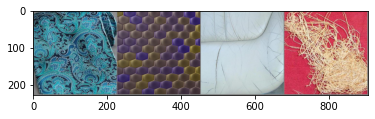

GroundTruth:  paisley honeycombed cracked fibrous
Pridicted:  scaly honeycombed gauzy cobwebbed
Accuracy of the network on the 380 test images: 16 %


In [19]:
test_dataset = PatternDataset(test_images, class_to_int, mode='test', transforms=transform)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=True, num_workers=0)

dataiter = iter(testloader)
images, labels = dataiter.next()

#이미지 출력
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))


# net.load_state_dict(torch.load(PATH))
#로드할때 윗줄 주석처리하고 밑 두줄 주석제거
# net = torch.load(PATH)
# net.eval()
outputs = net(images)

_, predicted =torch.max(outputs, 1)
print('Pridicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))
# 전체 데이터 셋에 대한 결과 확인
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy of the network on the 380 test images: %d %%' % (100*correct/total))